# NGSolve in Jupyter-Notebook

Of course, in a Jupyter-Book we can also intregrate Jupyter-Notebooks directly. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from ngsolve.meshes import MakeStructured2DMesh
from ngsolve import *
from ngsolve.solvers import Newton
from ngsolve.webgui import Draw

#mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
mesh = MakeStructured2DMesh(quads=False,nx=6,ny=6, mapping = lambda x,y : (x,y))

As example we are looking for solutions to the so-called Gelfands equation:

$$- \Delta u = \lambda e^u \quad \ \text{for}\ x \in \Omega$$

with Dirichlet boundary condition $u=0$ on $\partial\Omega$. From the analysis of the equation we know that for $\Omega \subset \mathbb{R}^2$ there exists a $0 < \lambda^* < \infty$ such that for $0 < \lambda < \lambda^*$ we have two solutions. To compute this solutions numerically we use a FEM $H^1$ discretisation and a path tracking method.

The main idea in pseudoarclength continuation is to drop the natural parametrization by $\lambda$ and use somit other parametrization {cite}`keller`. Consider the equation

$$G(u,\lambda) = 0$$(eq:Gelfand)

where $G: H_0^1(\Omega) \times \mathbb{R} \to \mathbb{R}$. If $(u_0, \lambda_0)$ is any point on a regular path and $(\dot{u}, \dot{\lambda})$ is the unit tangent to the path, then we adjoin to {eq}`eq:Gelfand` the scalar normalization:

$$N(u, \lambda, s) = \theta\ \langle\dot{u}_0, (u-u_0)\rangle + (1-\theta)\ \dot{\lambda}_0 \cdot (\lambda - \lambda_0) - (s-s_0) = 0$$(eq:pseudoarc)

Now we solve {eq}`eq:Gelfand` and {eq}`eq:pseudoarc` simultaneously for $(u(s), \lambda(s))$. For the implementation with `ngsolve` we use a product space. For $u$ a $H^1$-FE space and for $\lambda$ a numberspace:

In [ ]:
order = 4
V = H1(mesh, order=order, dirichlet='bottom|right|top|left')
W = NumberSpace(mesh)
X = V*W
# proxy-functions for X
(u,lam) = X.TrialFunction()
(v,q) = X.TestFunction()

# solution
gfx = GridFunction(X)
gfu, gflam = gfx.components
# linearization point
gfx0 = GridFunction(X)
gfu0, gflam0 = gfx0.components
# tangent to the path
dgfx0 = GridFunction(X)
dgfu0, dgflam0 = dgfx0.components
# old tangent to the path 
dgfx0_ = GridFunction(X)
dgfu0_, dgflam0_ = dgfx0_.components

AOmega = Integrate(1,mesh)
s0 = Parameter(0)
s = Parameter(0)

theta = Parameter(0.75)
aX = BilinearForm(X)
aX += (grad(u)*grad(v)-lam*exp(u)*v)*dx
aX += (theta*dgfu0*(u-gfu0)*q+(1-theta)*dgflam0*(lam-gflam0)/AOmega*q-(s-s0)/AOmega*q)*dx

We will briefly describe how to compute the tangent vectors $(\dot{u}_0, \dot{\lambda}_0)$. They must satisfy

$$\begin{split}
G_u^0 \dot{u}_0 + G_\lambda^0 \dot{\lambda}_0 & = 0\\
\theta\ \| \dot{u}_0\|^2 + (1-\theta)\ |\dot{\lambda}_0|^2 & = 1
\end{split}$$(eq:tangentvectors)

For a regular point $G_u^0$ is nonsingular. We find $\phi_0$ from the first equation of {eq}`eq:tangentvectors`

$$G_u^0 \phi_0 = -G_\lambda^0 \dot{\lambda}_0$$

Then set

$$\dot{u}_0 = a\,\phi_0\quad\text{and}\quad\dot{\lambda}_0 = a$$

where $a$ is determined from the second equation of {eq}`eq:tangentvectors`

$$a = \frac{\pm 1}{\sqrt{(1-\theta)+ \theta\,\|\phi_0\|^2}}.$$

In `ngsolve` we define the linearization as follows

In [5]:
u,v = V.TnT()
dGlam0 = LinearForm(V)
dGlam0 += -exp(gfu0)*v*dx

dGlam = LinearForm(V)
dGlam += -exp(gfu)*v*dx

dGu0 = BilinearForm(V)
dGu0 += (grad(u)*grad(v)-gflam0*exp(gfu0)*u*v)*dx

The initial solution for $\lambda = 0$ is given by $u\equiv 0$.

In [6]:
gflam0.Set(0)
gfu0.vec[:] = 0
gfx.vec.data = gfx0.vec

Now we can compute the path

In [ ]:
dGlam0.Assemble()
dGu0.Assemble()
dgfu0.vec.data = -dGu0.mat.Inverse(V.FreeDofs())*dGlam0.vec
dgflam0.Set(1/np.sqrt(theta.Get()*Integrate(dgfu0*dgfu0,mesh)+(1-theta.Get())))
dgfu0.vec.data *= dgflam0.vec[0]
dgfx0_.vec.data = dgfx0.vec

lami = [gflam.vec[0]]
mip = mesh(0.5,0.5)
soli = [gfu(mip)]

deltas = 1e-2
N = 100
M = 10

theta.Set(0.75)

scene = Draw(gfu);

In [11]:
for i in range(N):
    for j in range(M):
        s.Set(s.Get()+deltas)
        # solving the coupled system
        ret = Newton(aX, gfx, printing=False)
        soli.append(gfu(mip))
        lami.append(gflam.vec[0])
        j += 1
    scene.Redraw()
    s0.Set(s.Get())
    gfx0.vec.data = gfx.vec
    dGlam0.Assemble()
    dGu0.Assemble()
    dgfu0.vec.data = -dGu0.mat.Inverse(V.FreeDofs())*dGlam0.vec
    dgflam0.Set(1/np.sqrt(theta.Get()*Integrate(dgfu0*dgfu0,mesh)+(1-theta.Get())))
    dgfu0.vec.data *= dgflam0.vec[0]

    sign = Integrate(dgfu0*dgfu0_,mesh)+dgflam0.vec[0]*dgflam0_.vec[0]
    if sign < 0:
        dgfx0.vec.data *= -1
    dgfx0_.vec.data = dgfx0.vec
    print(i, '/',N,'dlam0=',dgflam0.vec[0], 'lambda=',gflam.vec[0])

0 / 100 dlam0= 1.9948907983346944 0.01 0.02068197609183093
1 / 100 dlam0= 1.9946789818801463 0.01 0.22016065625407247
2 / 100 dlam0= 1.9944520455154295 0.01 0.41961741825654664
3 / 100 dlam0= 1.9942084157660522 0.01 0.6190506740914699
4 / 100 dlam0= 1.993946299997702 0.01 0.8184586679062015
5 / 100 dlam0= 1.9936636476061675 0.01 1.0178394522448377
6 / 100 dlam0= 1.9933581027606686 0.01 1.2171908600115189
7 / 100 dlam0= 1.9930269464945136 0.01 1.416510471208029
8 / 100 dlam0= 1.9926670252574281 0.01 1.6157955732463112
9 / 100 dlam0= 1.9922746621208363 0.01 1.815043113305518
10 / 100 dlam0= 1.991845545560039 0.01 2.014249640764222
11 / 100 dlam0= 1.9913745889775054 0.01 2.2134112371503787
12 / 100 dlam0= 1.990855751658484 0.01 2.4125234302554053
13 / 100 dlam0= 1.9902818083284333 0.01 2.6115810879680272
14 / 100 dlam0= 1.9896440493959657 0.01 2.8105782858706125
15 / 100 dlam0= 1.9889318865062047 0.01 3.0095081405133794
16 / 100 dlam0= 1.988132326907266 0.01 3.208362597246179
17 / 100 dla

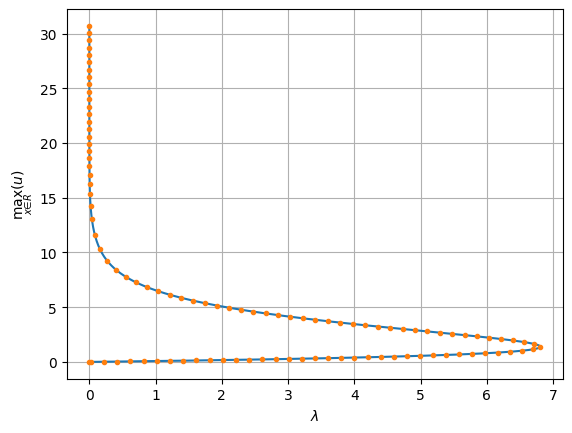

In [12]:
plt.plot(lami,soli,'-')
plt.plot(lami[::M],soli[::M],'.')
plt.grid()
plt.xlabel('$\lambda$')
plt.ylabel('$\max_{x\in R}(u)$')
plt.show()